# MLSS 2019: Optimal Transport for Machine Learning

In this second practical session, we will apply OT in two different Machine Learning applications:
1. Color Transfer
2. Document Clustering

In Color Transfer, we will mainly be interested in the optimal transport plan itself, while in Document Clustering, we will be interested in the value of the Optimal Transport / Wasserstein distance.

<b>We are going to use Google Collab to run this notebook. In order to install all the necessary files run the following cells:</b>

In [2]:
import os
!pip install --upgrade git+https://github.com/mlss-skoltech/tutorials.git#subdirectory=optimal_transport_tutorial

  Cloning https://github.com/mlss-skoltech/tutorials.git to /tmp/pip-req-build-hsaemp3d
  Running command git clone -q https://github.com/mlss-skoltech/tutorials.git /tmp/pip-req-build-hsaemp3d
You should consider upgrading via the '/home/amaltsev/env-tf114/bin/python3.6 -m pip install --upgrade pip' command.


In [3]:
# Check your installation by importing POT
!pip install pot
import ot

You should consider upgrading via the '/home/amaltsev/env-tf114/bin/python3.6 -m pip install --upgrade pip' command.


In [4]:
import pkg_resources
import os

# DATA_PATH = pkg_resources.resource_filename('optimaltransport', 'data/')
DATA_PATH = os.path.join('/media', 'disk2', 'amaltsev', 'car_lp_generator')

<b>If you are running this notebook locally, make sure to clone the tutorial repository:</b>

```!pip install --upgrade git+https://github.com/mlss-skoltech/tutorials.git#subdirectory=optimal_transport_tutorial```



And install the following package:

* Install with pip: ```bash pip install pot```
* Install with conda: ```bash conda install -c conda-forge pot ```

In [5]:
import numpy as np
import ot

## 1. Color Transfer

Given a source and a target image, the goal of color transfer is to transform the colors of the source image so that it looks similar to the target image color palette. In the end, we want to find a "color mapping", giving for each color of the source image a new color. This can be done by computing the optimal transport plan between the two images, seen as point clouds in the RGB space.

In [6]:
# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imsave
from mpl_toolkits.mplot3d import Axes3D

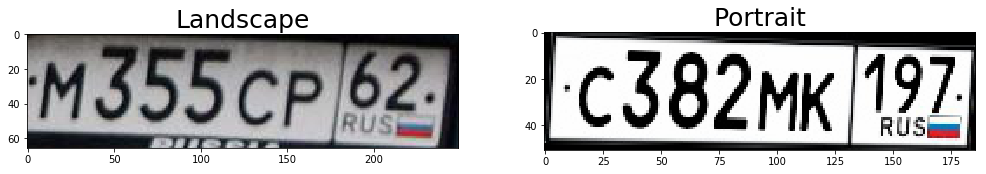

In [7]:
# Load the images
I1 = imread(os.path.join(DATA_PATH, 'old_data', 'plates', 'car_0037.jpg')).astype(np.float64) / 256
I2 = imread(os.path.join(DATA_PATH, 'old_data', 'rendered', 'test', 'car_0023_C382MK197.jpg')).astype(np.float64) / 256

fig = plt.figure(figsize=(17, 30))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(I1)
ax.set_title('Landscape', fontsize=25)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(I2)
ax.set_title('Portrait', fontsize=25)

plt.show()

We will need to work with "matrices" instead of images. Since there are 3 colors, images have shape `(Width, Height, 3)`, and the corresponding matrices will have shape `(Width*Height, 3)`.

In [8]:
def im2mat(I):
    '''Convert image I to matrix.'''
    return I.reshape(-1,3)

def mat2im(X, shape):
    '''Convert matrix X to image with shape 'shape'.'''
    return X.reshape(shape)

X1 = im2mat(I1)
X2 = im2mat(I2)

Real images have way too many different colors, so we will need to subsample them. In order to do this, we use K-means over all the colors, and keep only the computed centroids. Note that using Mini Batch K-Means will speed the computations up.

In [9]:
from sklearn.cluster import MiniBatchKMeans

# Size of the subsampled point clouds
nbsamples = 1000

kmeans1 = MiniBatchKMeans(n_clusters=nbsamples, init_size=nbsamples).fit(X1)
X1_sampled = kmeans1.cluster_centers_

kmeans2 = MiniBatchKMeans(n_clusters=nbsamples, init_size=nbsamples).fit(X2)
X2_sampled = kmeans2.cluster_centers_

Each image is represented by its "matrix", i.e. is seen as a point cloud $X \in \mathbb{R}^{N\times3}$ in the RGB color space, identified with $\mathbb{R}^3$. 

In [10]:
def showImageAsPointCloud(X, Y):
    '''Show the color palette associated with images X and Y.'''
    fig = plt.figure(figsize=(17,8))
    ax = fig.add_subplot(121, projection='3d')
    ax.set_xlim(0,1)
    ax.scatter(X[:,0], X[:,1], X[:,2], c=X, s=10, marker='o', alpha=0.6)
    ax.set_xlabel('R',fontsize=22)
    ax.set_xticklabels([])
    ax.set_ylim(0,1)
    ax.set_ylabel('G',fontsize=22)
    ax.set_yticklabels([])
    ax.set_zlim(0,1)
    ax.set_zlabel('B',fontsize=22)
    ax.set_zticklabels([])
    ax.set_title('Landscape Color Palette', fontsize=20)
    ax.grid('off')
    
    ax = fig.add_subplot(122, projection='3d')
    ax.set_xlim(0,1)
    ax.scatter(Y[:,0], Y[:,1], Y[:,2], c=Y, s=10, marker='o', alpha=0.6)
    ax.set_xlabel('R',fontsize=22)
    ax.set_xticklabels([])
    ax.set_ylim(0,1)
    ax.set_ylabel('G',fontsize=22)
    ax.set_yticklabels([])
    ax.set_zlim(0,1)
    ax.set_zlabel('B',fontsize=22)
    ax.set_zticklabels([])
    ax.set_title('Portrait Color Palette', fontsize=20)
    ax.grid('off')
    
    plt.show()

/home/amaltsev/env3/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


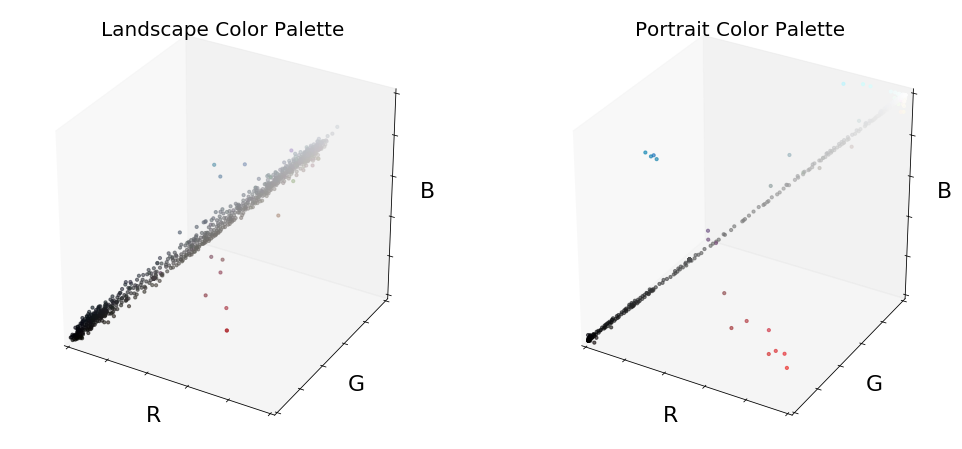

In [11]:
showImageAsPointCloud(X1_sampled, X2_sampled)

In order to compute the optimal transport plans between the two point clouds, we have to compute the corresponding cost matrix. In the following, we will always consider the squared distance, _i.e._ $C_{ij} = \|X_i - Y_j\|^2$.

In [12]:
ones = np.ones((nbsamples,nbsamples))
XX = np.diag(np.diag(X1_sampled.dot(X1_sampled.T))).dot(ones)
YY = ones.dot(np.diag(np.diag(X2_sampled.dot(X2_sampled.T))))
XY = X1_sampled.dot(X2_sampled.T)
C = XX + YY - 2*XY

### Landscape with Portrait colors

Here, the goal is to transfer the colors of the portrait to the landscape. We will compute the exact Optimal Transport Plan, as well as the Entropy Regularized Optimal Transport plans.

In [13]:
regs = [0.01, 0.1, 0.5]
OT_plans = []
OT_plans.append(ot.emd(np.ones(nbsamples), np.ones(nbsamples), C))
for reg in regs:
    OT_plans.append(ot.sinkhorn(np.ones(nbsamples), np.ones(nbsamples), C, reg=reg))

In [14]:
def colorTransfer(OT_plan, kmeans1, kmeans2, shape):
    '''Return the color-transfered image of shape "shape".'''
    samples_transformed = OT_plan.dot(kmeans2.cluster_centers_)
    X1_transformed = samples_transformed[kmeans1.labels_]
    return mat2im(X1_transformed, shape)

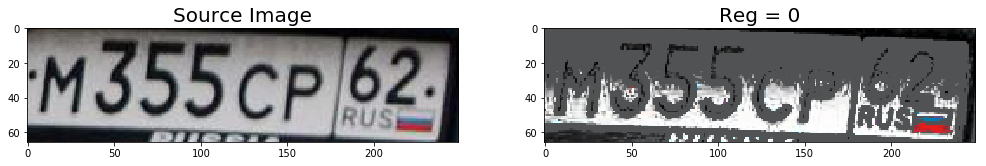

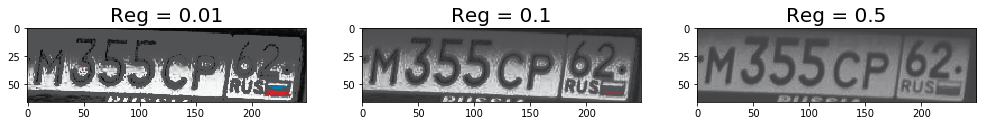

In [15]:
fig = plt.figure(figsize=(17, 20))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(I1)
ax.set_title('Source Image', fontsize=20)

ax = fig.add_subplot(1, 2, 2)
I = colorTransfer(OT_plans[0], kmeans1, kmeans2, I1.shape)
ax.imshow(I)
ax.set_title('Reg = 0', fontsize=20)

plt.show()

fig = plt.figure(figsize=(17, 20))
for i in range(3):
    ax = fig.add_subplot(2, 3, i+1)
    I = colorTransfer(OT_plans[i+1], kmeans1, kmeans2, I1.shape)
    ax.imshow(I)
    ax.set_title('Reg = '+str(regs[i]), fontsize=20)

plt.show()

### Portait with Landscape colors

We now transfer the colors of the landscape to the portrait.

In [16]:
C = np.ascontiguousarray(C.T)

In [17]:
regs = [0.01, 0.03, 0.1]
OT_plans = []
OT_plans.append(ot.emd(np.ones(nbsamples), np.ones(nbsamples), C))
for reg in regs:
    OT_plans.append(ot.sinkhorn(np.ones(nbsamples), np.ones(nbsamples), C, reg=reg))

In [18]:
def colorTransfer(OT_plan, kmeans1, kmeans2, shape):
    samples_transformed = OT_plan.dot(kmeans1.cluster_centers_)
    X2_transformed = samples_transformed[kmeans2.labels_]
    return mat2im(X2_transformed, shape)

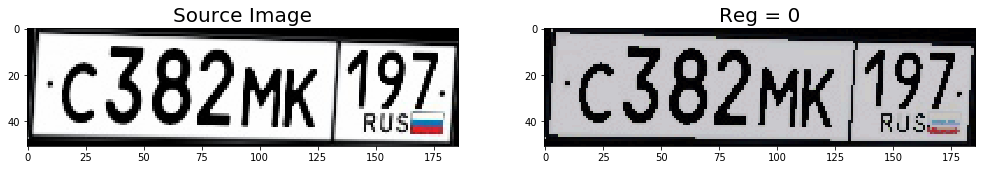

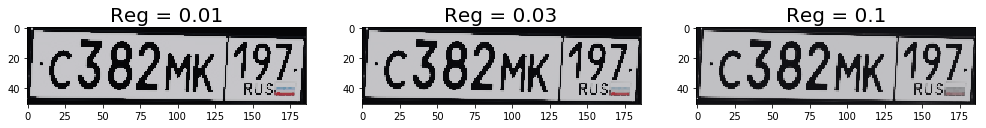

In [19]:
fig = plt.figure(figsize=(17, 20))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(I2)
ax.set_title('Source Image', fontsize=20)

ax = fig.add_subplot(1, 2, 2)
I = colorTransfer(OT_plans[0], kmeans1, kmeans2, I2.shape)
ax.imshow(I)
ax.set_title('Reg = 0', fontsize=20)
plt.show()

fig = plt.figure(figsize=(17, 20))
for i in range(3):
    ax = fig.add_subplot(2, 3, i+1)
    I = colorTransfer(OT_plans[i+1], kmeans1, kmeans2, I2.shape)
    ax.imshow(I)
    ax.set_title('Reg = '+str(regs[i]), fontsize=20)

plt.show()

In [20]:
DATA_PATH = '/media/disk2/amaltsev/car_lp_generator'
import time
start_time = time.time()
i = 0
for img_name in sorted(os.listdir(os.path.join(DATA_PATH, 'style_src_sq'))):
    if img_name[0] == '.':
        continue
        
    I1 = imread(os.path.join(DATA_PATH, 'style_src_sq', img_name)).astype(np.float64) / 256
    I2 = imread(os.path.join(DATA_PATH, 'style_dst_sq', img_name)).astype(np.float64) / 256
    
    X1 = im2mat(I1)
    X2 = im2mat(I2)
    
    kmeans1 = MiniBatchKMeans(n_clusters=nbsamples, init_size=nbsamples).fit(X1)
    X1_sampled = kmeans1.cluster_centers_

    kmeans2 = MiniBatchKMeans(n_clusters=nbsamples, init_size=nbsamples).fit(X2)
    X2_sampled = kmeans2.cluster_centers_
    
    ones = np.ones((nbsamples,nbsamples))
    XX = np.diag(np.diag(X1_sampled.dot(X1_sampled.T))).dot(ones)
    YY = ones.dot(np.diag(np.diag(X2_sampled.dot(X2_sampled.T))))
    XY = X1_sampled.dot(X2_sampled.T)
    C = XX + YY - 2*XY
    
    C = np.ascontiguousarray(C.T)
    
    OT_plan = ot.sinkhorn(np.ones(nbsamples), np.ones(nbsamples), C, reg=0.01)
    I = colorTransfer(OT_plan, kmeans1, kmeans2, I2.shape)
    
    imsave(os.path.join(DATA_PATH, 'transferred_ot', img_name), I)
    
    i += 1
    print(i)
    print((time.time() - start_time) / i)

1
29.941536903381348
2
28.886890292167664
3
26.70063654581706
4
21.881793558597565
5
24.41314082145691
6
21.722326795260113
7
20.370683125087194
8
20.55894061923027
9
19.10555617014567
10
19.511778354644775
11
18.378792242570356
12
17.39203490813573
13
18.13949759189899
14
17.40792657647814
15
16.77094381650289
16
17.49358044564724
17
18.975278097040512
18
18.437401056289673
19
17.84366716836628
20
17.358393132686615
21
17.70319398244222
22
18.117772015658293
23
17.67702959931415
24
18.08121606707573
25
18.353095769882202
26
18.695894736510056
27
18.299506885034067
28
18.786598682403564
29
18.41475143103764
30
18.09780062039693
31
18.625355858956613
32
19.026062488555908
33
18.717356233885795
34
18.413574625464047
35
18.08751232283456
36
18.134568598535324
37
17.90508890796352
38
18.164908810665732
39
18.55641496487153
40
19.0952596783638
41
19.160128837678492
42
18.969904587382363
43
19.149876483651095
44
18.940834484317087
45
18.744057427512274
46
18.983633839565776
47
18.78467009929

KeyboardInterrupt: 

## 2. Document Clustering

We would likle to classify several text documents. In order to do this, we will:
1. Transform each text into a point cloud
2. Compute the Optimal Transport distances between each pair of point clouds
3. Use MDS to plot the different clusters in 2 dimensions

### Load the Data and Preprocessing
We consider seven movie scenarios. We transformed each of them into a point cloud using the following steps:
1. Keep only the words among the $2.000 - 20.000$ most common words
2. Each remaining word is transformed into a $300$-dimensional vector using word2vec
3. Each word is given a weight proportional to its frequency

The variable `texts` is a list of tuples. Each tuple represents a movie, and contains two parts:
1. A matrix $X \in \mathbb{R}^{n \times 300}$ where $n$ is the number of different words, containing the position of the points
2. A vector $a \in \mathbb{R}^n$ containing the corresponding weights

In [41]:
import pickle

with open(DATA_PATH + 'texts.pickle', 'rb') as file:
    texts = pickle.load(file)

movies = ['DUNKIRK', 'GRAVITY', 'INTERSTELLAR', 'KILL BILL VOL.1', 'KILL BILL VOL.2', 'THE MARTIAN', 'TITANIC']

FileNotFoundError: [Errno 2] No such file or directory: '/media/disk2/amaltsev/car_lp_generatortexts.pickle'

### Compute the OT distances

In [ ]:
# Set regularization strength
reg = 0.1

In [ ]:
def costMatrix(i,j):
    '''Return the cost matrix C between movies number i and j.'''
    X = texts[i][0]
    ni = X.shape[0]
    Y = texts[j][0]
    nj = Y.shape[0]
    
    ones = np.ones((ni,nj))
    
    XX = np.diag(np.diag(X.dot(X.T))).dot(ones)
    YY = ones.dot(np.diag(np.diag(Y.dot(Y.T))))
    XY = X.dot(Y.T)
    
    return XX + YY - 2*XY

In [ ]:
OT_distances = np.zeros((7,7))
for i in range(7):
    for j in range(i+1,7):
        C = costMatrix(i,j)
        a = texts[i][1]
        b = texts[j][1]
        OT_plan = ot.sinkhorn(a, b, C, reg=reg)
        OT_distances[i,j] = np.sum(C*OT_plan)
        OT_distances[j,i] = OT_distances[i,j]

### Plot the MDS projection

In [ ]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity='precomputed')
dis = OT_distances - OT_distances[OT_distances>0].min()
np.fill_diagonal(dis, 0.)
embedding = embedding.fit(dis)
X = embedding.embedding_

import matplotlib.pyplot as plt
plt.figure(figsize=(17,6))
plt.scatter(X[:,0], X[:,1], alpha=0.)
plt.axis('equal')
plt.axis('off')
c = {'KILL BILL VOL.1':'red', 'KILL BILL VOL.2':'red', 'TITANIC':'blue', 'DUNKIRK':'blue', 'GRAVITY':'black', 'INTERSTELLAR':'black', 'THE MARTIAN':'black'}
for film in movies:
    i = movies.index(film)
    plt.gca().annotate(film, X[i], size=30, ha='center', color=c[film], weight="bold", alpha=0.7)
plt.show()